In [1]:
!/opt/conda/bin/python3.7 -m pip install --upgrade pip
!pip install seqeval

### Modelo Deep learning NER con bilstm y crf - model-04-tfa-fastText-(Scielo+wiki-uncased-cbow)+(char-50)

### Definicion de Parametro e Hiperparametros del Modelo

In [2]:
import sys
sys.path.append('../input/libsutils')

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pickle
import pandas as pd
from itertools import islice

from tabulate import tabulate
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report as eskclarep
from seqeval.metrics import precision_score, recall_score, f1_score, accuracy_score
from seqeval.metrics import classification_report as seqclarep
from sklearn.preprocessing import LabelBinarizer
from itertools import chain

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Concatenate, Lambda, Input, LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, InputLayer, Activation, Flatten
from tensorflow.keras.optimizers import Adam, schedules
from crfta import CRF as crf4
from utils import build_matrix_embeddings as bme, plot_model_performance, logits_to_tokens, report_to_df

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import TensorBoard

from IPython.core.display import display, HTML

import datetime, os
import random

SEED = 42
os.environ['PYTHONHASHSEED']=str(SEED)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'  # TF 2.1+
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

MODEL         = 'model-04-tfa-fastText-(Scielo+wiki-cased-cbow)+(char-50)'
logs_base_dir = "./logs"
log_dir       = logs_base_dir + "/" + MODEL
save_base_dir = './model-save'
save_dir      = save_base_dir + "/" + MODEL

os.makedirs(logs_base_dir, exist_ok=True)
os.makedirs(log_dir,       exist_ok=True)
os.makedirs(save_base_dir, exist_ok=True)
os.makedirs(save_dir,      exist_ok=True)

%load_ext tensorboard

# ****** DEFINICION DE PARAMETROS *********

#NUM_WORDS   = 12154 + 2
#LEN_SENTS   = 153
#NUM_TAGS    = 19 + 2

NUM_WORDS   = 12071 + 2
LEN_SENTS   = 153
NUM_TAGS    = 30 + 2

# ****** DEFINICION DE HIPERPARAMETROS *********
_EPOCHS      = 50 #50
EMBED_DIM    = 300
CHAR_EMBEDD  = 50
_DROPOUT     = 0.5
REC_DROPOUT  = 0.1
LEARN_RATE   = 1e-3
N_TRAIN      = int(1e4)
EP_DECAY     = 1e-8
BETA_1       = 0.9
BETA_2       = 0.999
_BACH_SIZE   = 500
VAL_SPLIT    = 0.1
STEPS_PER_EPOCH = N_TRAIN//_BACH_SIZE


gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

path_vectors     = '../input/new-lung-vectors/'
path_embeddings1 = '../input/embedding/'

1 Physical GPUs, 1 Logical GPUs


## Se cargan los datos de Entrenamiento

In [3]:
test_sentences = []
print("path: " + path_vectors)
with open(path_vectors + "sentences_test.txt", "rb") as fp:
    test_sentences = pickle.load(fp)

print(test_sentences[0])

## ********** Oraciones ********** ##
word2idx = np.load(path_vectors + 'word2index.npy', allow_pickle=True).item()
tag2idx  = np.load(path_vectors + 'tag2index.npy', allow_pickle=True).item()
idx2tag  = np.load(path_vectors + 'index2tag.npy', allow_pickle=True).item()

X_train = np.load(path_vectors + 'X_train.npy')
X_test  = np.load(path_vectors + 'X_test.npy')
X_dev   = np.load(path_vectors + 'X_dev.npy')

y_train  = np.load(path_vectors + 'y_train.npy')
y_test   = np.load(path_vectors + 'y_test.npy')
y_dev    = np.load(path_vectors + 'y_dev.npy')

path: ../input/new-lung-vectors/
[('Mujer', 'O'), ('de', 'O'), ('78', 'B_QUANTITY'), ('años', 'B_METRIC'), ('con', 'O'), ('FX', 'O'), ('EDR', 'O'), ('izdo', 'O'), ('el', 'O'), ('29/08', 'B_DATE'), ('.', 'O')]


## Pruebas de carga de datos

In [4]:
#print('**** Diccionario de palabras: ****\n')
#for key, value in word2idx.items():
#    if value == 10:
#        break
#    else:
#        print(key, ' : ', value)
        
#print(X_train[0])
#print(len(X_train))

#print(y_train[0])
print(len(y_train))
#print(len(y_test))
#print(len(y_dev))

9788


### Se carga el embedding de palabras

In [5]:
file1 = path_embeddings1 + 'ScieloWiki_cbow_cased.vec'
#file2 ='../input/new-lung-vectors/char_embedding_lung.txt'
file2 = '../input/new-lung-vectors/char_embedding_new.txt'
embedding_matrix = np.concatenate([bme(file1, NUM_WORDS, EMBED_DIM, word2idx),
                                   bme(file2, NUM_WORDS, CHAR_EMBEDD, word2idx)], axis=1)

Cargando archivo...


0it [00:00, ?it/s]

Encontrado 474554 Word Vectors.


  0%|          | 0/12073 [00:00<?, ?it/s]

Convertidos: 8164 Tokens | Perdidos: 4694 Tokens
Cargando archivo...


0it [00:00, ?it/s]

Encontrado 10824 Word Vectors.


  0%|          | 0/12073 [00:00<?, ?it/s]

Convertidos: 10718 Tokens | Perdidos: 1398 Tokens


## Definición del Modelo

In [6]:
#strategy = tf.distribute.MirroredStrategy()

#with strategy.scope():
# Input Layer
input1 = Input(shape=(LEN_SENTS,), dtype='int32')

# Embedding Layer
sentences = Embedding(NUM_WORDS,
                    EMBED_DIM + CHAR_EMBEDD,
                    input_length=LEN_SENTS,  
                    weights=[embedding_matrix],
                    trainable=False,
                    mask_zero=True)(input1)

# BI-LSTM Layer
myModel = Bidirectional(LSTM(EMBED_DIM + CHAR_EMBEDD, 
                             return_sequences=True
                            ),
                        name='bilstm1')(sentences)

# TimeDistributed Layer
myModel  = TimeDistributed(Dropout(_DROPOUT))(myModel)
myModel  = TimeDistributed(Dense(units=(EMBED_DIM + CHAR_EMBEDD)*2, activation='relu'))(myModel)
myModel  = TimeDistributed(Dense(units=NUM_TAGS, activation='relu'))(myModel)

# CRF Layer
crf= crf4(NUM_TAGS, sparse_target=True, name='crf_layer')

merged_chain = crf(myModel)

model = Model(inputs=input1, outputs=merged_chain)

model.compile(optimizer='Nadam', loss=crf.loss, metrics=[crf.accuracy])

model.summary()

/opt/conda/lib/python3.7/site-packages/tensorflow/python/autograph/impl/api.py:390: UserWarning: CRF Decoding does not work with KerasTensors in TF2.4. The bug has since been fixed in tensorflow/tensorflow##45534
  return py_builtins.overload_of(f)(*args)


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 153)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 153, 350)          4225550   
_________________________________________________________________
bilstm1 (Bidirectional)      (None, 153, 700)          1962800   
_________________________________________________________________
time_distributed (TimeDistri (None, 153, 700)          0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 153, 700)          490700    
_________________________________________________________________
time_distributed_2 (TimeDist (None, 153, 32)           22432     
_________________________________________________________________
crf_layer (CRF)              (None, 153, 32)           1024  

## Entranamiento del modelo

In [7]:
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Fit the best model
history = model.fit(X_train, y_train, 
                      validation_data  = (X_dev, y_dev),
                      batch_size       = _BACH_SIZE, 
                      epochs           = _EPOCHS,
                      verbose          = 1, 
                      callbacks        = [tensorboard_callback])

Epoch 1/50
20/20 [==============================] - 31s 945ms/step - loss: 54.2351 - viterbi_accuracy: 0.0671 - val_loss: 554.2197 - val_viterbi_accuracy: 0.0924
Epoch 2/50
20/20 [==============================] - 13s 679ms/step - loss: 51.0236 - viterbi_accuracy: 0.1738 - val_loss: 513.9360 - val_viterbi_accuracy: 0.3192
Epoch 3/50
20/20 [==============================] - 13s 642ms/step - loss: 50.1865 - viterbi_accuracy: 0.3178 - val_loss: 507.9955 - val_viterbi_accuracy: 0.3216
Epoch 4/50
20/20 [==============================] - 13s 633ms/step - loss: 49.1280 - viterbi_accuracy: 0.3193 - val_loss: 502.2161 - val_viterbi_accuracy: 0.3229
Epoch 5/50
20/20 [==============================] - 13s 664ms/step - loss: 48.9676 - viterbi_accuracy: 0.3230 - val_loss: 496.3498 - val_viterbi_accuracy: 0.3247
Epoch 6/50
20/20 [==============================] - 13s 640ms/step - loss: 47.8572 - viterbi_accuracy: 0.3229 - val_loss: 490.4227 - val_viterbi_accuracy: 0.3269
Epoch 7/50
20/20 [==========

### se almacena el modelo

In [8]:
# serialize model to JSON
model_json = model.to_json()
with open(save_dir + "/" + MODEL + ".json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights(save_dir + "/" + MODEL + ".h5")
print("Saved model to disk")

Saved model to disk


### Evaluamos el modelo y calculamos el valor de precision con respecto a los datos de prueba

In [9]:
print(y_test[0][0], "\n")
print(len(y_test))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0.] 

2496


In [10]:
scores = model.evaluate(X_test, y_test)
print(f"{model.metrics_names[1]}: {scores[1] * 100}")

78/78 [==============================] - 22s 246ms/step - loss: 149.7713 - viterbi_accuracy: 0.9073
viterbi_accuracy: 90.72896242141724


###  Procedemos a Graficar el comportamiento del Entrenamiento, tanto del conjunto de entrenamiento como el de validación con respecto a la cantidad de epocas

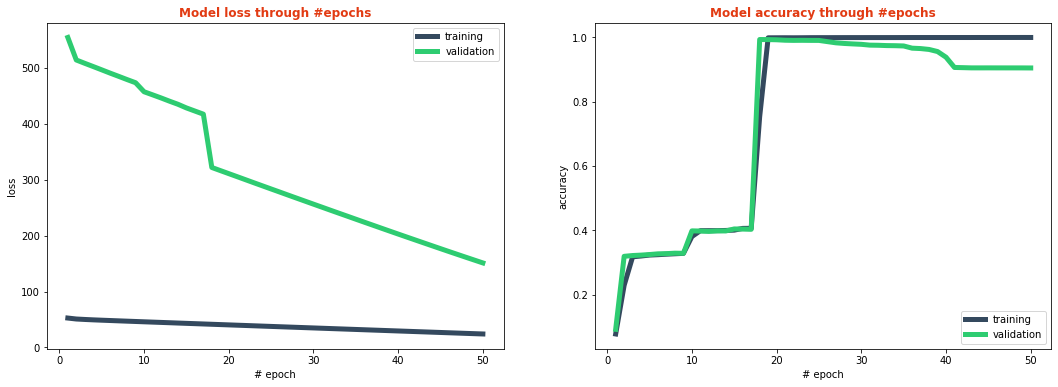

In [11]:
plot_model_performance(
    train_loss     = history.history.get('loss', []),
    train_acc      = history.history.get('viterbi_accuracy', []),
    train_val_loss = history.history.get('val_loss', []),
    train_val_acc  = history.history.get('val_viterbi_accuracy', [])
)

### Hacemos la prediccion sobre el conjunto de pruebas

In [12]:
print(idx2tag[6])
prediction = model.predict(X_test)

B_RADIOTHERAPY


In [13]:
y_pred = logits_to_tokens(np.argmax(prediction, -1), idx2tag)

In [14]:
print(y_pred[0], "\n")
print(test_sentences[0])

['O', 'O', 'B_QUANTITY', 'B_METRIC', 'O', 'O', 'O', 'O', 'O', 'B_DATE', 'O', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD

### Hallamos los valores de F1 score, recall, precision

In [15]:
y_true = []
for i, oracion in enumerate(test_sentences):
    row_sent = []
 
    for j, lista_palabras in enumerate(oracion):
        row_sent.append(lista_palabras[1])

    qekk = ['-PAD-'] * LEN_SENTS

    qekk[:len(row_sent)] = row_sent
    y_true.append(qekk)

In [16]:
prub = np.argmax(y_test, axis=-1)
print(idx2tag)
#print(prub[0])
#print(y_true[0])
#print(len(y_true))
#print(len(y_true[0]))
#print(len(y_true[1]), "\n")

{2: 'B_FAMILY', 3: 'I_FREQ', 4: 'I_DATE', 5: 'B_SMOKER_STATUS', 6: 'B_RADIOTHERAPY', 7: 'B_DATE', 8: 'B_FREQ', 9: 'I_STAGE', 10: 'I_SMOKER_STATUS', 11: 'I_CANCER_CONCEPT', 12: 'I_DRUG', 13: 'B_SURGERY', 14: 'I_IMPLICIT_DATE', 15: 'I_OCURRENCE_EVENT', 16: 'B_STAGE', 17: 'I_TNM', 18: 'I_SURGERY', 19: 'B_CHEMOTHERAPY', 20: 'I_METRIC', 21: 'B_METRIC', 22: 'B_CANCER_CONCEPT', 23: 'B_QUANTITY', 24: 'B_OCURRENCE_EVENT', 25: 'B_TNM', 26: 'I_FAMILY', 27: 'O', 28: 'B_DRUG', 29: 'B_IMPLICIT_DATE', 30: 'B_INTERVAL', 31: 'I_INTERVAL', 0: '-PAD-', 1: '-OOV-'}


In [17]:
li1 = sum(y_true, [])
li2 = sum(y_pred, [])

results = pd.DataFrame(columns=['Expected', 'Predicted'])

results['Expected'] = li1
results['Predicted'] = li2

In [18]:
#hh1 = seqclarep(results['Expected'], results['Predicted'])
#print('\nclassification_report:\n', hh1)


print("precision: {:.1%}".format(precision_score(y_true, y_pred)))
print("   recall: {:.1%}".format(recall_score(y_true,    y_pred)))
print(" accuracy: {:.1%}".format(accuracy_score(y_true,  y_pred)))
print(" F1-score: {:.1%}".format(f1_score(y_true,        y_pred)))

/opt/conda/lib/python3.7/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_QUANTITY seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/opt/conda/lib/python3.7/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_METRIC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/opt/conda/lib/python3.7/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_DATE seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/opt/conda/lib/python3.7/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: -PAD- seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/opt/conda/lib/python3.7/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: B_SMOKER_STATUS seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/opt/conda/lib/python3.7/site-packages/seqeval/metrics/sequen

precision: 89.3%
   recall: 92.7%
 accuracy: 99.7%
 F1-score: 91.0%


### Hallamos el calculo de cada una de las etiquetas por separado

In [19]:
report = eskclarep(results['Expected'], results['Predicted'])
print(report_to_df(report))

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           Class Name precision recall f1-score support
0               -PAD-      1.00   1.00     1.00  344240
1    B_CANCER_CONCEPT      0.95   0.95     0.95     689
2      B_CHEMOTHERAPY      0.98   0.99     0.99     191
3              B_DATE      0.95   0.91     0.93     779
4              B_DRUG      0.92   0.97     0.94     675
5            B_FAMILY      0.99   1.00     0.99     147
6              B_FREQ      0.78   0.97     0.87     161
7     B_IMPLICIT_DATE      0.36   0.65     0.47      26
8          B_INTERVAL      0.00   0.00     0.00      21
9            B_METRIC      0.94   0.96     0.95    1461
10  B_OCURRENCE_EVENT      0.89   0.91     0.90     597
11         B_QUANTITY      0.92   0.96     0.94    1493
12     B_RADIOTHERAPY      0.89   0.98     0.93      89
13    B_SMOKER_STATUS      0.82   0.93     0.87      55
14            B_STAGE      0.96   0.99     0.98     155
15          B_SURGERY      0.87   0.87     0.87     108
16              B_TNM      0.92   0.93     0.93 

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


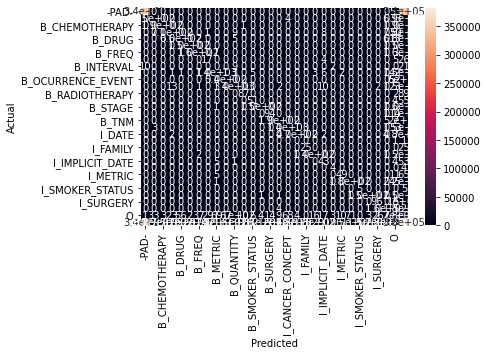

In [20]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

data = {'y_Actual':    results['Expected'],
        'y_Predicted': results['Predicted']
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'], margins = True)

sn.heatmap(confusion_matrix, annot=True)

plt.rcParams["figure.figsize"] = (20,10)
plt.show()

## Testing

### Creamos un pequeño Ejemplo

In [21]:
ner_samples = [
    "CICLO 2 CARBOPLATINO / PACLITAXEL . ".split(),
    "En Agosto de 2015 ha recibido 3 ciclos de CISPLATINO / VINORELBINA buena tolerancia clinica .".split(),
    "QT : CISPLATINO 75 mg / m2 DIA 1 IV + VINORELBINA 25 mg / m2 IV DIAS 1,8 - Adenocarcinoma pulmon lobulo superior derecho ".split(),
    "El dia 27 de junio iniciamos tratamiento con quimioterapia segun esquema CARBOPLATINO / PEMETREXED .".split(),
    "CICLO 1 CARBOPLATINO AUC 5 - PEMETREXED 500 mg/m2 IV cada 21 dias..".split(),
    "RT con dosis 50 Gy, se encuentra bien. .".split(),
    "Carcinoma escamoso de pulmón cT3 cN2 cM0 (al menos estadio IIIB de TNM 8ª ed .".split(),
    "Diagnosticado en marzo de 2016 de Adenoca de pulmón cT2cN2cM1a .".split(),
    "Ha sido diagnosticada de cancer de pulmon en marzo de 2019 .".split(),
    "Inicia tratamiento con Cisplatino + Pemetrexed + Bevacizumab (5 ciclos administrados, ultimo en enero de 2014).".split(),
    "Carcinoma escamoso de pulmón intervenido en marzo 2017 .".split(),
    "En 2014, intervenido de carcinoma de pulmón pT2bN1cM0 realizandose nefrectomia derecha .".split(),
    "carcinoma microcitico de pulmon t4 n2 m0 en tto quimioterapico: carboplatino / etoposido .".split(),
    "Colico renoureteral derecho con fracaso renal obstructivo en Julio de 2015 . ".split()
]






print("Ner: \n", ner_samples)



Ner: 
 [['CICLO', '2', 'CARBOPLATINO', '/', 'PACLITAXEL', '.'], ['En', 'Agosto', 'de', '2015', 'ha', 'recibido', '3', 'ciclos', 'de', 'CISPLATINO', '/', 'VINORELBINA', 'buena', 'tolerancia', 'clinica', '.'], ['QT', ':', 'CISPLATINO', '75', 'mg', '/', 'm2', 'DIA', '1', 'IV', '+', 'VINORELBINA', '25', 'mg', '/', 'm2', 'IV', 'DIAS', '1,8', '-', 'Adenocarcinoma', 'pulmon', 'lobulo', 'superior', 'derecho'], ['El', 'dia', '27', 'de', 'junio', 'iniciamos', 'tratamiento', 'con', 'quimioterapia', 'segun', 'esquema', 'CARBOPLATINO', '/', 'PEMETREXED', '.'], ['CICLO', '1', 'CARBOPLATINO', 'AUC', '5', '-', 'PEMETREXED', '500', 'mg/m2', 'IV', 'cada', '21', 'dias..'], ['RT', 'con', 'dosis', '50', 'Gy,', 'se', 'encuentra', 'bien.', '.'], ['Carcinoma', 'escamoso', 'de', 'pulmón', 'cT3', 'cN2', 'cM0', '(al', 'menos', 'estadio', 'IIIB', 'de', 'TNM', '8ª', 'ed', '.'], ['Diagnosticado', 'en', 'marzo', 'de', '2016', 'de', 'Adenoca', 'de', 'pulmón', 'cT2cN2cM1a', '.'], ['Ha', 'sido', 'diagnosticada', 'de', 

### Convertimos las Entradas del modelo

In [22]:
ner_samples_X    = []

for s1 in ner_samples:
    s1_int = []
    for w in s1:
        try:
            s1_int.append(word2idx[w.lower()])
        except KeyError:
            s1_int.append(word2idx['-OOV-'])
    ner_samples_X.append(s1_int)

ner_samples_X = pad_sequences(ner_samples_X, maxlen=LEN_SENTS, padding='post')


print("Examples: \n", ner_samples_X)



Examples: 
 [[ 2926  3770  4158 ...     0     0     0]
 [ 1044  8808  2706 ...     0     0     0]
 [    1  4616  7093 ...     0     0     0]
 ...
 [ 1044     1  2607 ...     0     0     0]
 [10469   531  2706 ...     0     0     0]
 [ 1628 10337  7713 ...     0     0     0]]


### Se ejecuta la predición con la entrada de ejemplo en el modelo entrenado

In [23]:
predictions1 = model.predict(ner_samples_X)
#predictions2 = model.predict(uncertainty_samples_X)
#predictions3 = model.predict(both_samples_X)

print("Examples: \n", predictions1, predictions1.shape)
#print("\nUncertainty: \n",predictions2, predictions2.shape)
#print(predictions3, predictions3.shape)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/autograph/impl/api.py:390: UserWarning: CRF Decoding does not work with KerasTensors in TF2.4. The bug has since been fixed in tensorflow/tensorflow##45534
  return py_builtins.overload_of(f)(*args)


Examples: 
 [[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]]

### Conversión de la salida del modelo a un lista de indices de tags

In [24]:
log_tokens1 = logits_to_tokens(np.argmax(predictions1, -1), idx2tag)
#log_tokens2 = logits_to_tokens(np.argmax(predictions2, -1), idx2tag)
#log_tokens3 = logits_to_tokens(np.argmax(predictions3, -1), idx2tag)


print("Ner: \n", log_tokens1[0])
#print("\nUncertainty: \n", log_tokens2[0])
#print("\nBoth: \n", log_tokens3[0])

Ner: 
 ['B_METRIC', 'B_QUANTITY', 'B_DRUG', 'O', 'B_DRUG', 'O', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', '-PAD-', 

## Resultado de Ner: 

In [25]:
for h, oracc in enumerate(ner_samples):
    heads = oracc
    body  = [log_tokens1[h][:len(oracc)]]
    display(HTML("<div style='overflow-x: auto; white-space: nowrap;'>" + 
                 tabulate(body, headers=heads, tablefmt="html") + 
                 "</div>"))

CICLO,2,CARBOPLATINO,/,PACLITAXEL,.
B_METRIC,B_QUANTITY,B_DRUG,O,B_DRUG,O


En,Agosto,de,2015,ha,recibido,3,ciclos,de,CISPLATINO,/,VINORELBINA,buena,tolerancia,clinica,.
O,B_DATE,I_DATE,I_DATE,O,O,B_QUANTITY,B_METRIC,O,B_DRUG,O,B_DRUG,O,O,O,O


QT,:,CISPLATINO,75,mg,/,m2,DIA,1,IV,+,VINORELBINA,25,mg,/,m2,IV,DIAS,"1,8",-,Adenocarcinoma,pulmon,lobulo,superior,derecho
B_QUANTITY,O,B_DRUG,B_QUANTITY,B_METRIC,O,B_METRIC,B_METRIC,B_QUANTITY,O,O,B_DRUG,B_QUANTITY,B_METRIC,O,B_METRIC,O,B_METRIC,B_QUANTITY,O,B_CANCER_CONCEPT,I_CANCER_CONCEPT,O,O,O


El,dia,27,de,junio,iniciamos,tratamiento,con,quimioterapia,segun,esquema,CARBOPLATINO,/,PEMETREXED,.
O,O,B_DATE,I_DATE,I_DATE,B_OCURRENCE_EVENT,I_OCURRENCE_EVENT,O,B_CHEMOTHERAPY,O,O,B_DRUG,O,B_DRUG,O


CICLO,1,CARBOPLATINO,AUC,5,-,PEMETREXED,500,mg/m2,IV,cada,21,dias..
B_METRIC,B_QUANTITY,B_DRUG,O,B_QUANTITY,O,B_DRUG,B_QUANTITY,B_METRIC,O,B_FREQ,I_FREQ,O


RT,con,dosis,50,"Gy,",se,encuentra,bien.,.
O,O,O,B_QUANTITY,O,O,O,O,O


Carcinoma,escamoso,de,pulmón,cT3,cN2,cM0,(al,menos,estadio,IIIB,de,TNM,8ª,ed,.
B_CANCER_CONCEPT,I_CANCER_CONCEPT,I_CANCER_CONCEPT,I_CANCER_CONCEPT,B_TNM,O,B_TNM,O,O,B_STAGE,I_STAGE,O,O,B_QUANTITY,B_METRIC,O


Diagnosticado,en,marzo,de,2016,de,Adenoca,de,pulmón,cT2cN2cM1a,.
B_OCURRENCE_EVENT,O,B_DATE,I_DATE,I_DATE,O,B_CANCER_CONCEPT,I_CANCER_CONCEPT,I_CANCER_CONCEPT,O,O


Ha,sido,diagnosticada,de,cancer,de,pulmon,en,marzo,de,2019,.
B_OCURRENCE_EVENT,O,B_OCURRENCE_EVENT,O,B_CANCER_CONCEPT,I_CANCER_CONCEPT,I_CANCER_CONCEPT,O,B_DATE,I_DATE,I_DATE,O


Inicia,tratamiento,con,Cisplatino,+,Pemetrexed,+,Bevacizumab,(5,ciclos,"administrados,",ultimo,en,enero,de,2014).
B_OCURRENCE_EVENT,I_OCURRENCE_EVENT,O,B_DRUG,O,B_DRUG,O,O,B_QUANTITY,B_METRIC,O,B_OCURRENCE_EVENT,O,B_DATE,I_DATE,I_DATE


Carcinoma,escamoso,de,pulmón,intervenido,en,marzo,2017,.
B_CANCER_CONCEPT,I_CANCER_CONCEPT,I_CANCER_CONCEPT,I_CANCER_CONCEPT,B_OCURRENCE_EVENT,O,B_DATE,I_DATE,O


En,"2014,",intervenido,de,carcinoma,de,pulmón,pT2bN1cM0,realizandose,nefrectomia,derecha,.
O,B_DATE,B_OCURRENCE_EVENT,O,B_CANCER_CONCEPT,I_CANCER_CONCEPT,I_CANCER_CONCEPT,B_TNM,O,B_SURGERY,I_SURGERY,O


carcinoma,microcitico,de,pulmon,t4,n2,m0,en,tto,quimioterapico:,carboplatino,/,etoposido,.
B_CANCER_CONCEPT,I_CANCER_CONCEPT,I_CANCER_CONCEPT,I_CANCER_CONCEPT,B_TNM,I_TNM,I_TNM,O,O,O,B_DRUG,O,B_DRUG,O


Colico,renoureteral,derecho,con,fracaso,renal,obstructivo,en,Julio,de,2015,.
O,O,O,O,O,O,O,O,B_DATE,I_DATE,I_DATE,O
